# COMP8220 - MAJOR PROJECT - IMAGE CLASSIFICATION
## Name : Phan Vinh Phu
## ID : 45747989

## Outline
### 1. Introduction
### 2. Install Dependencies and Setup
### 3. Data Preprocessing
### 4. Modelling 
> #### 4.1. Conventional Machine Learning models
> #### 4.2. CNN models
### 5. Summary

# **1. Introduction**

In recent years, image classification has become an increasingly important task in the field of computer vision. The ability to automatically classify images has a wide range of applications, from recognizing objects in photographs to identifying medical conditions in diagnostic images.

In this project, I will be working with a dataset of living things, which includes images of animals and plants. The dataset contains a set of coarse-grained labels, consisting of 8 different categories and another set of fine-grained which consists of 50 labels.

My goal is to develop a machine learning model that can accurately classify images in this dataset based on their category label. We will explore different machine learning algorithms and techniques, such as convolutional neural networks (CNNs), Random Forest, Supported Vector Machine,....

# **2. Install Dependencies and Setup**

In [ ]:
# !pip install tensorflow

## Import libraries

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Unzip data file

In [ ]:
# Your file will probably be called this, if you used the regular Kaggle download. 
# !unzip -q /content/drive/MyDrive/ImageClassification/living-thing-classification-coarse.zip

## Check GPU

In [2]:
print("Version: ",tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
GPU is available


## Define functions

In [12]:
# Initialize default variables
batch_size = 32
img_size = 224
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path("/kaggle/input/living-thing-classification-coarse/public/")

In [13]:
def load_target_names(path='/kaggle/input/living-thing-classification-coarse/public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=160):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

    
def create_dataset_tf(split, fine_grained, batch_size=32, image_size=160, percent=0.3):
    df = pd.read_csv(root / f"{split}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse
    labels = tf.one_hot(labels, num_classes) 

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    n_batches = int(len(dataset) * percent)
    dataset = dataset.take(n_batches)
    return dataset

def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
    dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
    dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    X = None
    Y = None
    n_batches = int(len(dataset) * percent)
    for x, y in dataset.take(n_batches):
        x, y = x.numpy(), y.numpy()
        x = x.reshape(x.shape[0], -1)
        y = np.argmax(y, axis=1)  # Convert one-hot encoded labels back to class indices
        X = x if X is None else np.vstack([X, x])
        Y = y if Y is None else np.hstack([Y, y])

    return X, Y

# **3. Data Preprocessing**
The images have dimensionality of varying dimensionality, and are in colour.  There will be two versions of test data, where the images are the same, but the labels are different: one set of labels is coarse-grained and consists of 8 labels, and the other is more fine-grained and consists of 50 labels.

## Load data

In [5]:
# Load target names from info.json file
fine_names, coarse_names = load_target_names()

# Coarse Names
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


These labels come from the [Class rank](https://en.wikipedia.org/wiki/Class_(biology) in the widely used Linnaean biological taxonomy; the 8 labels we are using are 'Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida'.

In [6]:
# Fine Names
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


The fine-grained labels come from the [Family rank](https://en.wikipedia.org/wiki/Family_(biology). One example of a fine-grained label is Family Scolopacidae representing [sandpipers](https://en.wikipedia.org/wiki/Sandpiper) (wading bird). Scolopacidae are part of Class Aves (broadly, [birds](https://en.wikipedia.org/wiki/Bird)).

## Create dataset for Scikit-Learn

In [ ]:
# X_train,Y_train = create_dataset_sklearn('train', fine_grained=False, image_size = img_size)
# X_val, Y_val = create_dataset_sklearn('val', fine_grained=False, image_size = img_size)
# X_test, Y_test = create_dataset_sklearn('test', fine_grained=False,image_size = img_size) 

Show first sixteen images and labels from tranning set:

In [ ]:
# plt.figure(figsize=(10, 10))

# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(X_train[i].reshape(160, 160), cmap='gray')
#     if fine_grain:
#         plt.title(fine_names[Y_train[i]])
#     else:
#         plt.title(coarse_names[Y_train[i]])
#     plt.axis("off")
# plt.show();

## Create dataset for TensorFlow

In [14]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, image_size=img_size, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, image_size=img_size, batch_size=batch_size)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, image_size=img_size, batch_size=batch_size)

In [15]:
print(len(train_ds))

937


Show first sixteen images and labels from tranning set:

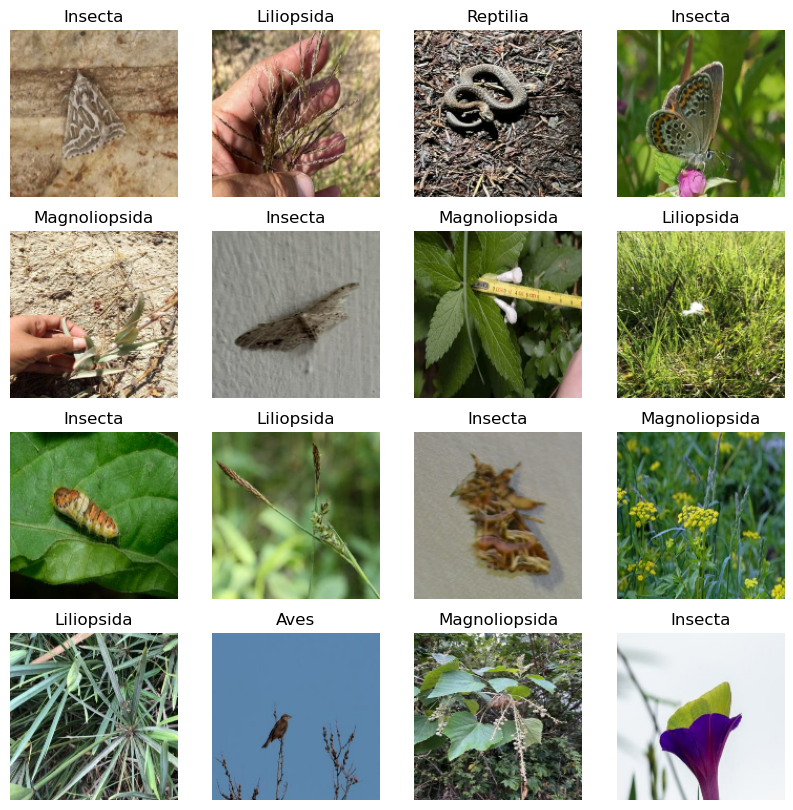

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
        plt.title(fine_names[int(np.where(labels[i] == 1)[0])])
#         plt.title(fine_names[labels[i]])
    else:
        plt.title(coarse_names[int(np.where(labels[i] == 1)[0])])
#         plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

# 4. Modelling

## 4.1 Conventional Machine Learning models

### Suport Vector Machine (SVMs) Model
Support Vector Machine (SVM) is one of the Machine Learning (ML) Supervised algorithms. There are plenty of algorithms in ML, but still, reception for SVM is always special because of its robustness while dealing with the data

#### Train the model

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Set the attributes
sigma = 0.1
gamma = 1/(2 * sigma*2)

clf_svm = svm.SVC(kernel='rbf', gamma = gamma, C = 1.0, decision_function_shape = 'ovr')
clf_svm.fit(X_train, Y_train)

#### Predict validation set

In [ ]:
svm_pred = clf_svm.predict(X_val)
print("Accuracy of SVMs Model : ", accuracy_score(Y_val, svm_pred))

### SVM with Cross-validation

In [ ]:
# Fine tuning with cross-validation
sigma = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

errors = list()
sigma_c = list()
for each in sigma:
    for each_c in C:
        clf = svm.SVC(kernel='rbf', gamma = 1/(2*(each**2)), C=each_c, decision_function_shape='ovr')
        clf.fit(X_train, Y_train)
        errors.append(clf.score(X_val, Y_val))
        sigma_c.append((each, each_c))

In [ ]:
index = np.argmax(errors)

sigma_max, c_max = sigma_c[index]

print('The optimal value of sigma is: {}'.format(sigma_max))
print('The optimal value of C is: {}'.format(c_max))

Now use the optimal values for sigma and for the regularisation parameter C to generate the hyperplane.

### Random Forest Model

Random Forest Model is an ensemble learning method that combines multiple decision trees to improve the accuracy and robustness of the model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=200,
                                random_state=42)

clf_rf.fit(X_train, Y_train)

rf_pred = clf_rf.predict(X_val)

print("Accuracy of Random Forrest Model : ", accuracy_score(Y_val, rf_pred))

One of the important hyperparameters of the random forest model is the number of trees, which controls the trade-off between bias and variance. Increasing the number of trees tends to decrease the bias and increase the variance, whereas reducing the number of trees tends to increase the bias and reduce the variance.

### Random Forest Model with RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]

# Create the param grid
param_grid = {'n_estimators': n_estimators}
param_grid

In [ ]:
rf_Model = RandomForestClassifier()

from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)

rf_Grid.fit(X_train, Y_train)

In [ ]:
rf_Grid.best_params_

In [ ]:
rf_Grid.score(X_val,Y_val)

### Saving predictions to csv file for Kaggle.

In [ ]:
y_pred = clf_rf.predict(X_test)

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "45747989_coarse_preds.csv"
test_csv.to_csv(pred_file)

## 4.2 Transfer learning

### EfficientNetV2S

#### Why use EfficientNetV2S?
- It saves time building a neural network from scratch.

- EfficientNetV2S is trained using a large images dataset. It enables the model to effectively learn, therefore, we can expect accurate results.

- EfficientNetV2S has achieved state-of-the-art performance on various benchmark datasets, including ImageNet, which demonstrates its effectiveness in image classification tasks

- It simplifies the process of image processing. Image processing helps transform the image dataset into a format that the model can understand to give more accurate results

- EfficientNetV2S introduces skip connections, also known as residual connections. These connections allow the gradient to flow directly through the network, mitigating the vanishing gradient problem and making it easier to train very deep networks

### Create the base model from the pre-trained convnets

In [28]:
input_shape=(img_size,img_size,3)

# rescale the input
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# Create base model
base_model = tf.keras.applications.EfficientNetV2S(weights = 'imagenet', 
                                             include_top = False, 
                                             input_shape = input_shape)

### Data augmentation

Applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

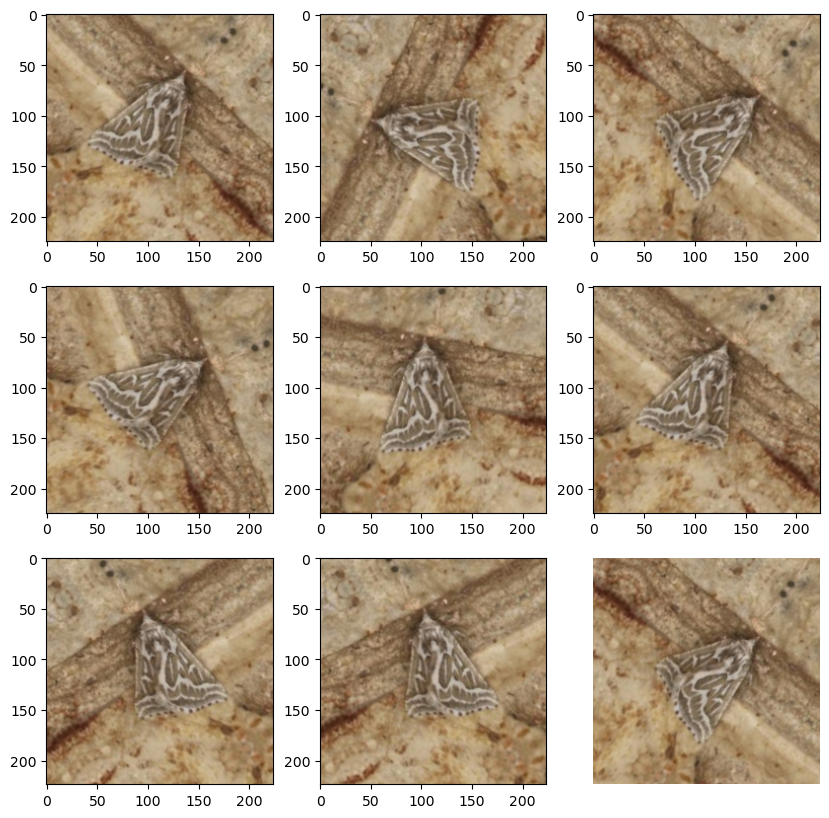

In [17]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
    plt.axis('off')

This feature extractor converts each `160x160x3` image into a `32x7x7x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

Build a model by chaining together rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

### Try with 30% dataset

#### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. `Convnext` has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [18]:
base_model.trainable = False

#### Buil the model

In [29]:
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(8, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.CategoricalCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [30]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [24]:
len(model.trainable_variables)

4

#### Train the model

In [32]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
937/937 [==============================] - 462s 382ms/step - loss: 1.2527 - accuracy: 0.5576 - val_loss: 0.9797 - val_accuracy: 0.6634
Epoch 2/10
937/937 [==============================] - 306s 326ms/step - loss: 0.9103 - accuracy: 0.6814 - val_loss: 0.8142 - val_accuracy: 0.7169
Epoch 3/10
937/937 [==============================] - 306s 327ms/step - loss: 0.7680 - accuracy: 0.7260 - val_loss: 0.7387 - val_accuracy: 0.7430
Epoch 4/10
937/937 [==============================] - 306s 326ms/step - loss: 0.6712 - accuracy: 0.7600 - val_loss: 0.7019 - val_accuracy: 0.7552
Epoch 5/10
937/937 [==============================] - 307s 327ms/step - loss: 0.5940 - accuracy: 0.7863 - val_loss: 0.6435 - val_accuracy: 0.7712
Epoch 6/10
937/937 [==============================] - 308s 328ms/step - loss: 0.5307 - accuracy: 0.8061 - val_loss: 0.6298 - val_accuracy: 0.7804
Epoch 7/10
937/937 [==============================] - 306s 327ms/step - loss: 0.4773 - accuracy: 0.8260 - val_loss: 0.6203 -

#### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the ResNet152V2 base model as a fixed feature extractor.

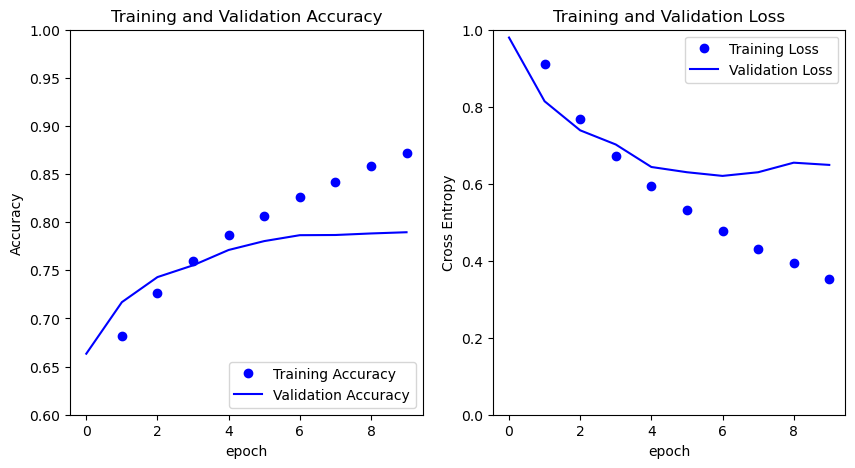

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ((ax1, ax2)) = plt.subplots(nrows = 1, 
                                 ncols = 2, 
                                 figsize = (10,5))

ax1.plot(acc,'bo', label='Training Accuracy')
ax1.plot(val_acc,'b', label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.60, 1.00)
ax1.title.set_text('Training and Validation Accuracy')
ax1.set_xlabel('epoch')

ax2.plot(loss, 'bo', label='Training Loss')
ax2.plot(val_loss, 'b', label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim(0, 1.00)
ax2.title.set_text('Training and Validation Loss')
ax2.set_xlabel('epoch')
plt.show()

#### Fine tuning

##### Un-freeze the top layers of the model

In [34]:
base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


#### Compile the model

In [37]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [38]:
len(model.trainable_variables)

365

#### Continue training the model

In [39]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
937/937 [==============================] - 290s 246ms/step - loss: 0.2936 - accuracy: 0.8935 - val_loss: 0.6387 - val_accuracy: 0.8030
Epoch 11/20
937/937 [==============================] - 227s 243ms/step - loss: 0.2879 - accuracy: 0.8966 - val_loss: 0.6376 - val_accuracy: 0.8046
Epoch 12/20
937/937 [==============================] - 228s 243ms/step - loss: 0.2750 - accuracy: 0.9014 - val_loss: 0.6530 - val_accuracy: 0.8057
Epoch 13/20
937/937 [==============================] - 229s 244ms/step - loss: 0.2692 - accuracy: 0.9028 - val_loss: 0.6550 - val_accuracy: 0.8060
Epoch 14/20
937/937 [==============================] - 229s 244ms/step - loss: 0.2618 - accuracy: 0.9060 - val_loss: 0.6630 - val_accuracy: 0.8055
Epoch 15/20
937/937 [==============================] - 229s 244ms/step - loss: 0.2562 - accuracy: 0.9084 - val_loss: 0.6684 - val_accuracy: 0.8062
Epoch 16/20
937/937 [==============================] - 229s 244ms/step - loss: 0.2551 - accuracy: 0.9086 - val_loss: 0

#### Learning curves

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

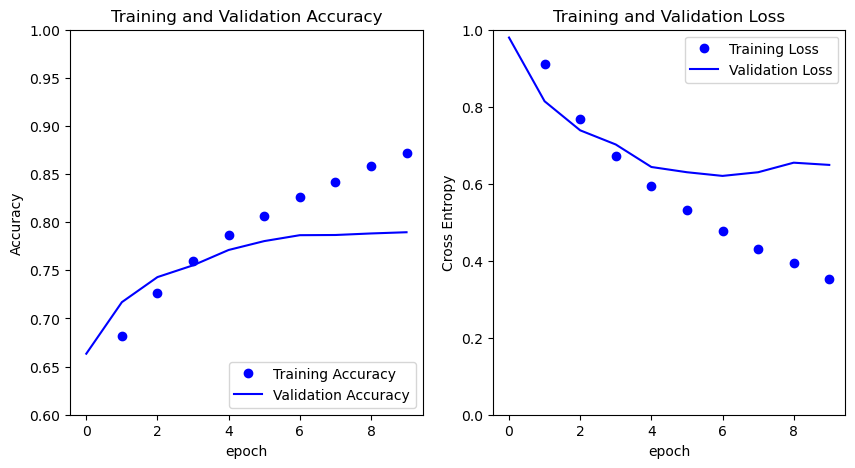

In [48]:
fig, ((ax3, ax4)) = plt.subplots(nrows = 1, 
                                 ncols = 2, 
                                 figsize = (10,5))

ax3.plot(acc,'bo', label='Training Accuracy')
ax3.plot(val_acc,'b', label='Validation Accuracy')
ax3.legend(loc='lower right')
ax3.set_ylabel('Accuracy')
ax3.set_ylim(0.60, 1.00)
ax3.title.set_text('Training and Validation Accuracy')
ax3.set_xlabel('epoch')

ax4.plot(loss, 'bo', label='Training Loss')
ax4.plot(val_loss, 'b', label='Validation Loss')
ax4.legend(loc='upper right')
ax4.set_ylabel('Cross Entropy')
ax4.set_ylim(0, 1.00)
ax4.title.set_text('Training and Validation Loss')
ax4.set_xlabel('epoch')
plt.show()

#### Save the model after training

In [49]:
model.save('kaggle/working/model.h5')

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [51]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

468/468 [==============================] - 34s 73ms/step - loss: 0.0000e+00 - accuracy: 0.2159
Test accuracy : 0.2159455120563507


**I am using 30% train data to train model. There is a significant overfitting problem here when model fit very well with train and val set (accuracy > 80%) but it performs a poor prediction for test dataset (accuracy = 21.5%). Let's try with 50% dataset**

### Increase the dataset to 50%

In [52]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, image_size=img_size, batch_size=batch_size, percent = 0.5)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, image_size=img_size, batch_size=batch_size, percent = 0.5)
test_ds = create_dataset_tf('test', fine_grained=fine_grain, image_size=img_size, batch_size=batch_size, percent = 0.5)

#### Freeze the base model

In [53]:
base_model.trainable = False

#### Recompile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.CategoricalCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [54]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [56]:
len(model.trainable_variables)

4

#### Train the model

In [57]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
1562/1562 [==============================] - 279s 169ms/step - loss: 0.3998 - accuracy: 0.8614 - val_loss: 0.5547 - val_accuracy: 0.8049
Epoch 2/10
1562/1562 [==============================] - 172s 110ms/step - loss: 0.3743 - accuracy: 0.8696 - val_loss: 0.5521 - val_accuracy: 0.8058
Epoch 3/10
1562/1562 [==============================] - 171s 109ms/step - loss: 0.3547 - accuracy: 0.8748 - val_loss: 0.5495 - val_accuracy: 0.8059
Epoch 4/10
1562/1562 [==============================] - 171s 110ms/step - loss: 0.3367 - accuracy: 0.8812 - val_loss: 0.5525 - val_accuracy: 0.8033
Epoch 5/10
1562/1562 [==============================] - 171s 109ms/step - loss: 0.3173 - accuracy: 0.8888 - val_loss: 0.5566 - val_accuracy: 0.8054
Epoch 6/10
1562/1562 [==============================] - 170s 109ms/step - loss: 0.3000 - accuracy: 0.8949 - val_loss: 0.5652 - val_accuracy: 0.8051
Epoch 7/10
1562/1562 [==============================] - 170s 109ms/step - loss: 0.2834 - accuracy: 0.9004 - val_

#### Fine tuning

This time , I will try to unfreeze all layers to explore the performance of new model with larger dataset

##### Un-freeze the base model

In [58]:
base_model.trainable = True

In [59]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  513


#### Recompile the model

In [60]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [61]:
len(model.trainable_variables)

454

**The number of trainable variable has been increased to 454.**

#### Continue training the model

In [62]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
1562/1562 [==============================] - 572s 321ms/step - loss: 0.2296 - accuracy: 0.9204 - val_loss: 0.5933 - val_accuracy: 0.8071
Epoch 11/20
1562/1562 [==============================] - 501s 321ms/step - loss: 0.2210 - accuracy: 0.9222 - val_loss: 0.5972 - val_accuracy: 0.8068
Epoch 12/20
1562/1562 [==============================] - 500s 320ms/step - loss: 0.2160 - accuracy: 0.9252 - val_loss: 0.5954 - val_accuracy: 0.8094
Epoch 13/20
1562/1562 [==============================] - 499s 320ms/step - loss: 0.2088 - accuracy: 0.9278 - val_loss: 0.6028 - val_accuracy: 0.8079
Epoch 14/20
1562/1562 [==============================] - 501s 321ms/step - loss: 0.2089 - accuracy: 0.9275 - val_loss: 0.6000 - val_accuracy: 0.8084
Epoch 15/20
1562/1562 [==============================] - 502s 321ms/step - loss: 0.2080 - accuracy: 0.9275 - val_loss: 0.6068 - val_accuracy: 0.8081
Epoch 16/20
1562/1562 [==============================] - 501s 321ms/step - loss: 0.1997 - accuracy: 0.9300

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [63]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

781/781 [==============================] - 96s 123ms/step - loss: 0.0000e+00 - accuracy: 0.2079
Test accuracy : 0.2079465389251709


# Summary